Using device: cuda

====================== PINN/DRM for P4, Example 1 ======================
DeepRitzNet(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=112, bias=True)
    (1-4): 4 x Linear(in_features=112, out_features=112, bias=True)
    (5): Linear(in_features=112, out_features=1, bias=True)
  )
)

Total trainable parameters: 51073

Hyperparameters:
  Layers          : [2, 112, 112, 112, 112, 112, 1]
  Adam epochs     : 30000
  Adam LR         : 0.001
  StepLR step     : 5000
  StepLR gamma    : 0.5
  LBFGS max_iter  : 500
  N_INT_POINTS    : 11000
  N_BD_POINTS     : 3000
  Lambdas         : INT=1.0, BC1=10.0, BC2=10.0
Epoch      1 | PDE_loss: 1.4709e+02 | L_bc1: 1.2808e-02 | L_bc2: 4.9619e+00 | LR: 1.00e-03
Epoch    500 | PDE_loss: 3.7231e-02 | L_bc1: 4.3824e-04 | L_bc2: 3.8567e-04 | LR: 1.00e-03
Epoch   1000 | PDE_loss: 2.1062e-02 | L_bc1: 3.7411e-04 | L_bc2: 1.9565e-04 | LR: 1.00e-03
Epoch   1500 | PDE_loss: 6.0525e-03 | L_bc1: 1.8597e-04 | L_bc2: 8.4298e-0

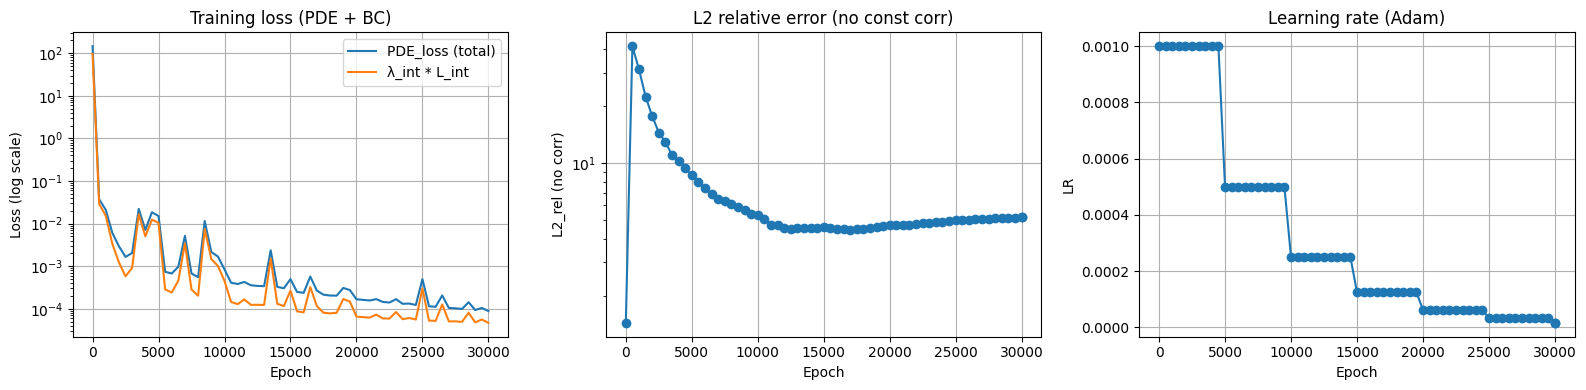

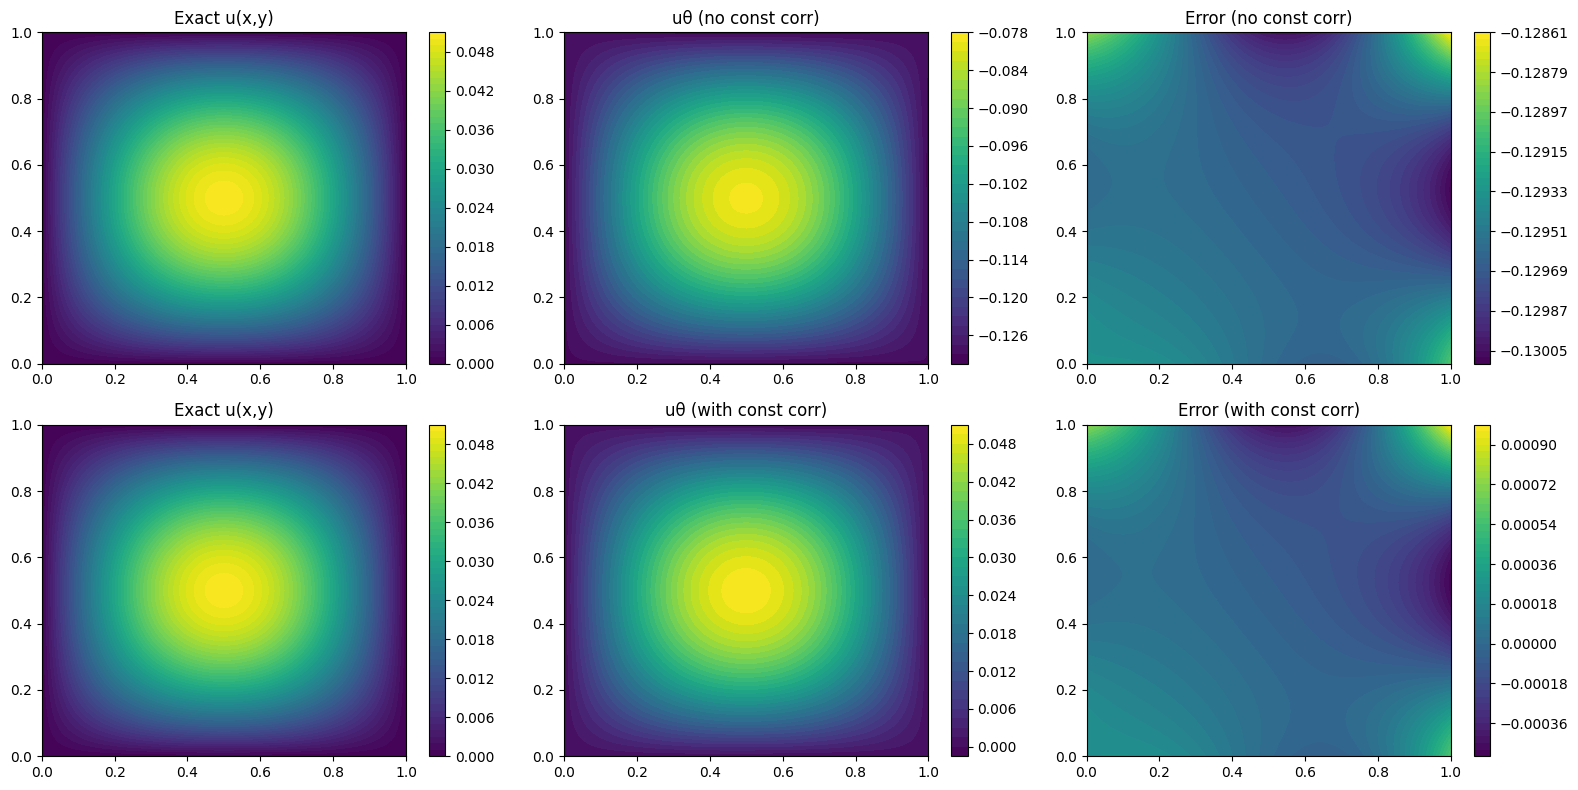

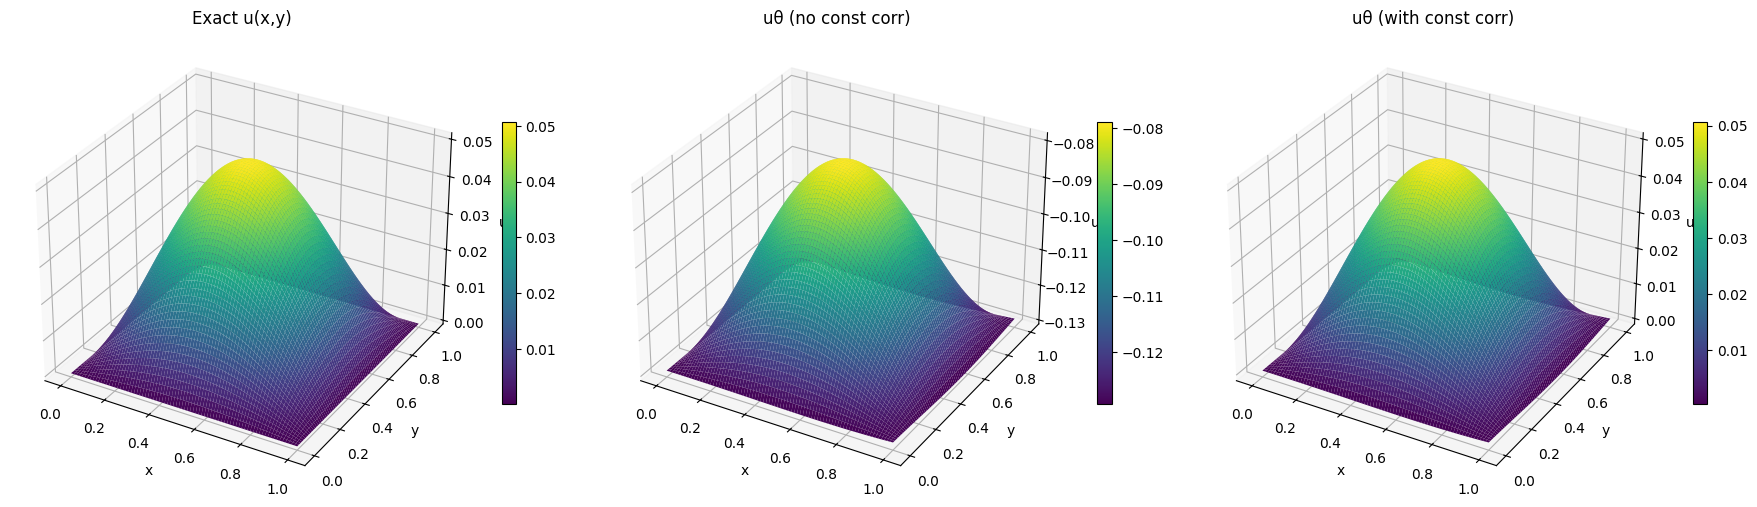

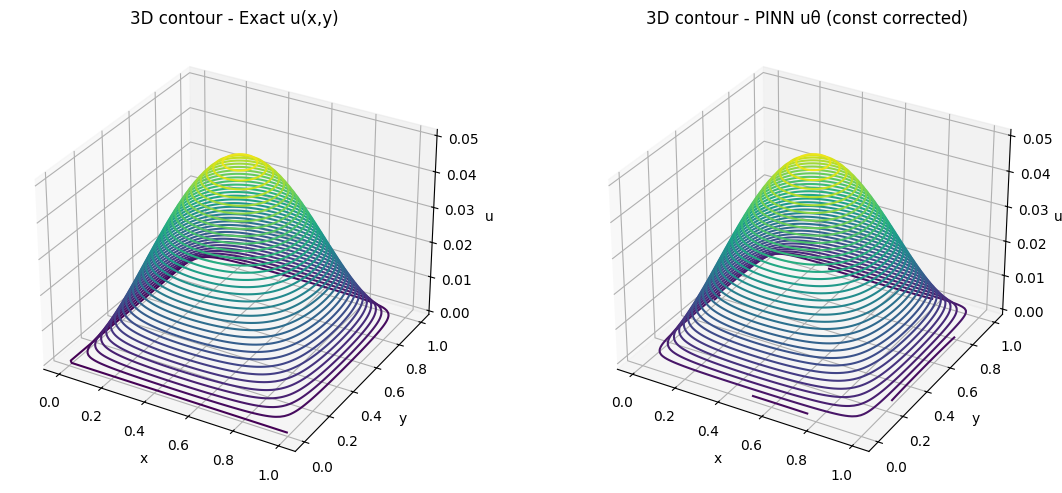


All plots saved in: p4_example1_PINN_results_lambdas_tuned


In [3]:
import os, time, math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ============================================================
# Global setup
# ============================================================
torch.set_default_dtype(torch.float64)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

out_dir = "p4_example1_PINN_results_lambdas_tuned"
os.makedirs(out_dir, exist_ok=True)

# ============================================================
# Example 1: Biharmonic P4 on (0,1)^2
#   Δ²u = f in Ω
#   ∂u/∂n = g1,  ∂(Δu)/∂n = g2 on ∂Ω
#
#   u(x,y) = 1/(2π²) sin(πx) sin(πy)
#   f = Δ²u, g1 = ∂u/∂n, g2 = ∂Δu/∂n
#
# Exact u is used ONLY to build f,g1,g2 and to compute errors.
# ============================================================

def u_exact(xy: torch.Tensor) -> torch.Tensor:
    x = xy[:, 0:1]
    y = xy[:, 1:2]
    return (1.0 / (2.0 * torch.pi**2)) * torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

def f_rhs(xy: torch.Tensor) -> torch.Tensor:
    x = xy[:, 0:1]
    y = xy[:, 1:2]
    return 2.0 * (torch.pi**2) * torch.sin(torch.pi * x) * torch.sin(torch.pi * y)

def grad_u_exact(xy: torch.Tensor) -> torch.Tensor:
    x = xy[:, 0:1]
    y = xy[:, 1:2]
    u_x = (1.0 / (2.0 * torch.pi)) * torch.cos(torch.pi * x) * torch.sin(torch.pi * y)
    u_y = (1.0 / (2.0 * torch.pi)) * torch.sin(torch.pi * x) * torch.cos(torch.pi * y)
    return torch.cat([u_x, u_y], dim=1)

def grad_lap_u_exact(xy: torch.Tensor) -> torch.Tensor:
    # Δu = - sin(πx) sin(πy)
    x = xy[:, 0:1]
    y = xy[:, 1:2]
    lap_x = -torch.pi * torch.cos(torch.pi * x) * torch.sin(torch.pi * y)
    lap_y = -torch.pi * torch.sin(torch.pi * x) * torch.cos(torch.pi * y)
    return torch.cat([lap_x, lap_y], dim=1)

def hessian_u_exact(xy: torch.Tensor):
    x = xy[:, 0:1]
    y = xy[:, 1:2]
    # u_xx = -1/2 sin(πx) sin(πy)
    # u_yy = -1/2 sin(πx) sin(πy)
    # u_xy =  1/2 cos(πx) cos(πy)
    u_xx = -0.5 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y)
    u_yy = -0.5 * torch.sin(torch.pi * x) * torch.sin(torch.pi * y)
    u_xy =  0.5 * torch.cos(torch.pi * x) * torch.cos(torch.pi * y)
    return u_xx, u_xy, u_yy

def boundary_g1_g2(xy: torch.Tensor, normals: torch.Tensor):
    grad_u  = grad_u_exact(xy)
    gradlap = grad_lap_u_exact(xy)
    g1 = torch.sum(grad_u * normals, dim=1, keepdim=True)
    g2 = torch.sum(gradlap * normals, dim=1, keepdim=True)
    return g1, g2

# ============================================================
# Network
# ============================================================
class DeepRitzNet(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        self.layers = nn.ModuleList(
            [nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-1)]
        )
        self.activation = torch.tanh

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i < len(self.layers) - 1:
                x = self.activation(x)
        return x

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# ============================================================
# Differential operators via autograd
# ============================================================
def laplacian(u: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    grad_u = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]
    u_x = grad_u[:, 0:1]
    u_y = grad_u[:, 1:2]

    grad2_x = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u_x),
        create_graph=True,
        retain_graph=True
    )[0]
    grad2_y = torch.autograd.grad(
        u_y, x,
        grad_outputs=torch.ones_like(u_y),
        create_graph=True,
        retain_graph=True
    )[0]

    u_xx = grad2_x[:, 0:1]
    u_yy = grad2_y[:, 1:2]
    return u_xx + u_yy

def normal_derivative(u: torch.Tensor, x: torch.Tensor, normals: torch.Tensor) -> torch.Tensor:
    grad_u = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        create_graph=True,
        retain_graph=True
    )[0]
    return torch.sum(grad_u * normals, dim=1, keepdim=True)

def normal_derivative_of_laplacian(lap_u: torch.Tensor, x: torch.Tensor, normals: torch.Tensor) -> torch.Tensor:
    grad_lap = torch.autograd.grad(
        lap_u, x,
        grad_outputs=torch.ones_like(lap_u),
        create_graph=True,
        retain_graph=True
    )[0]
    return torch.sum(grad_lap * normals, dim=1, keepdim=True)

# ============================================================
# Sampling (base points, no grad)
# ============================================================
def sample_interior(N_int):
    return torch.rand(N_int, 2, device=device)

def sample_boundary(N_bd_total):
    N_side = N_bd_total // 4
    t_left  = torch.rand(N_side, 1, device=device)
    t_right = torch.rand(N_side, 1, device=device)
    t_bottom= torch.rand(N_side, 1, device=device)
    t_top   = torch.rand(N_side, 1, device=device)

    left    = torch.cat([torch.zeros_like(t_left), t_left], dim=1)     # x=0
    n_left  = torch.cat([-torch.ones_like(t_left), torch.zeros_like(t_left)], dim=1)

    right   = torch.cat([torch.ones_like(t_right), t_right], dim=1)    # x=1
    n_right = torch.cat([torch.ones_like(t_right), torch.zeros_like(t_right)], dim=1)

    bottom   = torch.cat([t_bottom, torch.zeros_like(t_bottom)], dim=1)  # y=0
    n_bottom = torch.cat([torch.zeros_like(t_bottom), -torch.ones_like(t_bottom)], dim=1)

    top   = torch.cat([t_top, torch.ones_like(t_top)], dim=1)          # y=1
    n_top = torch.cat([torch.zeros_like(t_top), torch.ones_like(t_top)], dim=1)

    X_bd_base = torch.cat([left, right, bottom, top], dim=0)
    normals   = torch.cat([n_left, n_right, n_bottom, n_top], dim=0)
    return X_bd_base, normals

# ============================================================
# Build model + data
# ============================================================
layer_sizes = [2, 112, 112, 112, 112, 112, 1]
net = DeepRitzNet(layer_sizes).to(device)

# Hyperparameters (your config)
EPOCHS_ADAM   = 30000
LR_ADAM       = 1e-3
STEP_SIZE     = 5000
GAMMA         = 0.5
LBFGS_MAX_ITER = 500

N_INT_POINTS  = 11000
N_BD_POINTS   = 3000

# Lambdas: emphasize interior PDE
LAMBDA_INT    = 1.0
LAMBDA_BC1    = 10.0
LAMBDA_BC2    = 10.0

print("\n====================== PINN/DRM for P4, Example 1 ======================")
print(net)
print("\nTotal trainable parameters:", count_parameters(net))
print("\nHyperparameters:")
print(f"  Layers          : {layer_sizes}")
print(f"  Adam epochs     : {EPOCHS_ADAM}")
print(f"  Adam LR         : {LR_ADAM}")
print(f"  StepLR step     : {STEP_SIZE}")
print(f"  StepLR gamma    : {GAMMA}")
print(f"  LBFGS max_iter  : {LBFGS_MAX_ITER}")
print(f"  N_INT_POINTS    : {N_INT_POINTS}")
print(f"  N_BD_POINTS     : {N_BD_POINTS}")
print(f"  Lambdas         : INT={LAMBDA_INT}, BC1={LAMBDA_BC1}, BC2={LAMBDA_BC2}")

# Base collocation points (no grad)
X_int_base = sample_interior(N_INT_POINTS)
X_bd_base, normals_bd = sample_boundary(N_BD_POINTS)

with torch.no_grad():
    f_int          = f_rhs(X_int_base)
    g1_bd, g2_bd   = boundary_g1_g2(X_bd_base, normals_bd)

# Evaluation grid
GRID_N_EVAL = 81
xs = torch.linspace(0.0, 1.0, GRID_N_EVAL, device=device)
ys = torch.linspace(0.0, 1.0, GRID_N_EVAL, device=device)
Xv, Yv = torch.meshgrid(xs, ys, indexing="ij")
X_eval_grid = torch.stack([Xv.reshape(-1), Yv.reshape(-1)], dim=1)
u_exact_eval_grid = u_exact(X_eval_grid)

# ============================================================
# Loss function
# ============================================================
def compute_losses(model):
    """
    Returns:
      total_loss (MSE),
      L_int, L_bc1, L_bc2 (MSE),
      residual_rms = sqrt(L_int)
    """
    X_int = X_int_base.clone().detach().requires_grad_(True)
    X_bd  = X_bd_base.clone().detach().requires_grad_(True)

    u_int   = model(X_int)
    lap_int = laplacian(u_int, X_int)
    bi_lap  = laplacian(lap_int, X_int)     # Δ²u

    res_int = bi_lap - f_int
    L_int   = torch.mean(res_int**2)

    u_bd   = model(X_bd)
    lap_bd = laplacian(u_bd, X_bd)

    du_dn   = normal_derivative(u_bd,   X_bd, normals_bd)
    dlap_dn = normal_derivative_of_laplacian(lap_bd, X_bd, normals_bd)

    L_bc1 = torch.mean((du_dn   - g1_bd)**2)
    L_bc2 = torch.mean((dlap_dn - g2_bd)**2)

    total_mse  = LAMBDA_INT * L_int + LAMBDA_BC1 * L_bc1 + LAMBDA_BC2 * L_bc2
    total_loss = total_mse

    residual_rms = torch.sqrt(torch.clamp(L_int, min=1e-30))
    return total_loss, L_int, L_bc1, L_bc2, residual_rms

# ============================================================
# Optimizers
# ============================================================
optimizer_adam = torch.optim.Adam(net.parameters(), lr=LR_ADAM)
scheduler      = torch.optim.lr_scheduler.StepLR(optimizer_adam, step_size=STEP_SIZE, gamma=GAMMA)

optimizer_lbfgs = torch.optim.LBFGS(
    net.parameters(),
    lr=1.0,
    max_iter=LBFGS_MAX_ITER,
    history_size=50,
    line_search_fn="strong_wolfe"
)

# ============================================================
# History containers
# ============================================================
history_epochs   = []
history_loss     = []
history_Lint     = []
history_Lbc1     = []
history_Lbc2     = []
history_L2rel    = []
history_res_rms  = []
history_lr       = []

LOG_FREQ = 500  # you can change if you want denser/sparser logs

# ============================================================
# Adam loop
# ============================================================
start_time = time.time()
net.train()

for epoch in range(1, EPOCHS_ADAM + 1):
    optimizer_adam.zero_grad()
    total_loss, L_int, L_bc1, L_bc2, residual_rms = compute_losses(net)
    total_loss.backward()
    optimizer_adam.step()
    scheduler.step()

    if epoch == 1 or epoch % LOG_FREQ == 0 or epoch == EPOCHS_ADAM:
        # record history (for plots)
        net.eval()
        with torch.no_grad():
            u_pred_eval = net(X_eval_grid)
            diff_eval   = u_pred_eval - u_exact_eval_grid
            num_L2 = torch.sqrt(torch.mean(diff_eval**2))
            den_L2 = torch.sqrt(torch.mean(u_exact_eval_grid**2))
            L2_rel = (num_L2 / den_L2).item()
        net.train()

        current_lr = optimizer_adam.param_groups[0]["lr"]

        history_epochs.append(epoch)
        history_loss.append(total_loss.item())
        history_Lint.append(L_int.item())
        history_Lbc1.append(L_bc1.item())
        history_Lbc2.append(L_bc2.item())
        history_L2rel.append(L2_rel)
        history_res_rms.append(residual_rms.item())
        history_lr.append(current_lr)

        # Minimal log: PDE_loss (total), BC losses, LR
        print(
            f"Epoch {epoch:6d} | "
            f"PDE_loss: {total_loss.item():.4e} | "
            f"L_bc1: {L_bc1.item():.4e} | "
            f"L_bc2: {L_bc2.item():.4e} | "
            f"LR: {current_lr:.2e}"
        )

adam_end = time.time()
print(f"\n[Adam] Finished in {adam_end - start_time:.2f} s ({(adam_end-start_time)/60.0:.2f} min)")

# ============================================================
# L-BFGS refinement
# ============================================================
print("\nStarting L-BFGS refinement ...")

def lbfgs_closure():
    optimizer_lbfgs.zero_grad()
    total_loss, L_int, L_bc1, L_bc2, residual_rms = compute_losses(net)
    total_loss.backward()
    return total_loss

lbfgs_start = time.time()
optimizer_lbfgs.step(lbfgs_closure)
lbfgs_end = time.time()

print(f"[L-BFGS] Finished in {lbfgs_end - lbfgs_start:.2f} s ({(lbfgs_end-lbfgs_start)/60.0:.2f} min)")

total_train_time = lbfgs_end - start_time
print(f"\nTotal training time (Adam + L-BFGS): {total_train_time:.2f} s ({total_train_time/60.0:.2f} min)")

# ============================================================
# Final PDE_loss + L2_rel after L-BFGS (FIX: no torch.no_grad around compute_losses)
# ============================================================
net.eval()

# compute_losses needs grad tracking for autograd.grad (laplacian)
total_loss, L_int, L_bc1, L_bc2, residual_rms = compute_losses(net)

with torch.no_grad():
    u_pred_eval = net(X_eval_grid)
    diff_eval   = u_pred_eval - u_exact_eval_grid
    num_L2 = torch.sqrt(torch.mean(diff_eval**2))
    den_L2 = torch.sqrt(torch.mean(u_exact_eval_grid**2))
    L2_rel = (num_L2 / den_L2).item()

history_epochs.append(EPOCHS_ADAM + 1)
history_loss.append(total_loss.item())
history_Lint.append(L_int.item())
history_Lbc1.append(L_bc1.item())
history_Lbc2.append(L_bc2.item())
history_L2rel.append(L2_rel)
history_res_rms.append(residual_rms.item())
history_lr.append(optimizer_adam.param_groups[0]["lr"])

print(
    f"\n[After L-BFGS] | "
    f"PDE_loss: {total_loss.item():.4e} | "
    f"L_bc1: {L_bc1.item():.4e} | "
    f"L_bc2: {L_bc2.item():.4e} | "
    f"L2_rel(no-corr): {L2_rel:.4e}"
)

# ============================================================
# Final errors: before & after constant correction
# ============================================================
Xg = X_eval_grid.clone().detach().requires_grad_(True)
u_pred_g   = net(Xg)
u_exact_g  = u_exact(Xg)

grad_pred = torch.autograd.grad(
    u_pred_g, Xg,
    grad_outputs=torch.ones_like(u_pred_g),
    create_graph=True,
    retain_graph=True
)[0]
u_x_pred = grad_pred[:, 0:1]
u_y_pred = grad_pred[:, 1:2]

grad2_pred_x = torch.autograd.grad(
    u_x_pred, Xg,
    grad_outputs=torch.ones_like(u_x_pred),
    create_graph=True,
    retain_graph=True
)[0]
grad2_pred_y = torch.autograd.grad(
    u_y_pred, Xg,
    grad_outputs=torch.ones_like(u_y_pred),
    create_graph=True,
    retain_graph=True
)[0]
u_xx_pred = grad2_pred_x[:, 0:1]
u_xy_pred = grad2_pred_x[:, 1:2]
u_yy_pred = grad2_pred_y[:, 1:2]

grad_exact_g = grad_u_exact(Xg.detach())
u_x_exact = grad_exact_g[:, 0:1]
u_y_exact = grad_exact_g[:, 1:2]
u_xx_exact, u_xy_exact, u_yy_exact = hessian_u_exact(Xg.detach())

# ----- Without constant correction -----
err0    = u_pred_g - u_exact_g
err0_x  = u_x_pred - u_x_exact
err0_y  = u_y_pred - u_y_exact
err0_xx = u_xx_pred - u_xx_exact
err0_xy = u_xy_pred - u_xy_exact
err0_yy = u_yy_pred - u_yy_exact

L2_err0 = torch.sqrt(torch.mean(err0**2))
L2_ref  = torch.sqrt(torch.mean(u_exact_g**2))
L2_rel0 = (L2_err0 / L2_ref).item()

H1_err0 = torch.sqrt(torch.mean(
    err0**2 + err0_x**2 + err0_y**2
))
H1_ref  = torch.sqrt(torch.mean(
    u_exact_g**2 + u_x_exact**2 + u_y_exact**2
))
H1_rel0 = (H1_err0 / H1_ref).item()

H2_err0 = torch.sqrt(torch.mean(
    err0**2 + err0_x**2 + err0_y**2 +
    err0_xx**2 + err0_xy**2 + err0_yy**2
))
H2_ref  = torch.sqrt(torch.mean(
    u_exact_g**2 + u_x_exact**2 + u_y_exact**2 +
    u_xx_exact**2 + u_xy_exact**2 + u_yy_exact**2
))
H2_rel0 = (H2_err0 / H2_ref).item()

# ----- With constant correction -----
c_star = torch.mean(u_pred_g - u_exact_g)
u_pred_corr = u_pred_g - c_star

errc = u_pred_corr - u_exact_g
L2_errc = torch.sqrt(torch.mean(errc**2))
L2_relc = (L2_errc / L2_ref).item()

H1_errc = H1_err0
H1_relc = H1_rel0
H2_errc = H2_err0
H2_relc = H2_rel0

print("\nErrors WITHOUT constant correction (uθ):")
print(f"  L2_abs  ≈ {L2_err0.item():.4e}")
print(f"  L2_rel  ≈ {L2_rel0:.4e}")
print(f"  H1_abs  ≈ {H1_err0.item():.4e}")
print(f"  H1_rel  ≈ {H1_rel0:.4e}")
print(f"  H2_abs  ≈ {H2_err0.item():.4e}")
print(f"  H2_rel  ≈ {H2_rel0:.4e}")

print("\nErrors WITH constant correction (uθ -> uθ - c*):")
print(f"  L2_abs  ≈ {L2_errc.item():.4e}")
print(f"  L2_rel  ≈ {L2_relc:.4e}")
print(f"  H1_abs  ≈ {H1_errc.item():.4e}")
print(f"  H1_rel  ≈ {H1_relc:.4e}")
print(f"  H2_abs  ≈ {H2_errc.item():.4e}")
print(f"  H2_rel  ≈ {H2_relc:.4e}")

# ============================================================
# Training dynamics plots
# ============================================================
history_epochs_np  = np.array(history_epochs)
history_loss_np    = np.array(history_loss)
history_Lint_np    = np.array(history_Lint)
history_Lbc1_np    = np.array(history_Lbc1)
history_Lbc2_np    = np.array(history_Lbc2)
history_L2rel_np   = np.array(history_L2rel)
history_res_rms_np = np.array(history_res_rms)
history_lr_np      = np.array(history_lr)

plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.semilogy(history_epochs_np, history_loss_np, label="PDE_loss (total)")
plt.semilogy(history_epochs_np, LAMBDA_INT * history_Lint_np, label="λ_int * L_int")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("Training loss (PDE + BC)")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.semilogy(history_epochs_np, history_L2rel_np, marker='o')
plt.xlabel("Epoch")
plt.ylabel("L2_rel (no corr)")
plt.title("L2 relative error (no const corr)")
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(history_epochs_np, history_lr_np, marker='o')
plt.xlabel("Epoch")
plt.ylabel("LR")
plt.title("Learning rate (Adam)")
plt.grid(True)

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "training_dynamics.png"), dpi=300)
plt.show()

# ============================================================
# 2D contours (before & after constant correction)
# ============================================================
with torch.no_grad():
    u_pred_grid_nocorr = net(X_eval_grid).detach().cpu().numpy().reshape(GRID_N_EVAL, GRID_N_EVAL)
    u_exact_grid       = u_exact_eval_grid.detach().cpu().numpy().reshape(GRID_N_EVAL, GRID_N_EVAL)
    c_star_np          = float(c_star.detach().cpu().numpy())
    u_pred_grid_corr   = u_pred_grid_nocorr - c_star_np

    err_grid_nocorr = u_pred_grid_nocorr - u_exact_grid
    err_grid_corr   = u_pred_grid_corr   - u_exact_grid

Xv_np = Xv.detach().cpu().numpy()
Yv_np = Yv.detach().cpu().numpy()

plt.figure(figsize=(16, 8))

# Row 1: no correction
plt.subplot(2, 3, 1)
cf1 = plt.contourf(Xv_np, Yv_np, u_exact_grid, levels=50)
plt.colorbar(cf1)
plt.title("Exact u(x,y)")

plt.subplot(2, 3, 2)
cf2 = plt.contourf(Xv_np, Yv_np, u_pred_grid_nocorr, levels=50)
plt.colorbar(cf2)
plt.title("uθ (no const corr)")

plt.subplot(2, 3, 3)
cf3 = plt.contourf(Xv_np, Yv_np, err_grid_nocorr, levels=50)
plt.colorbar(cf3)
plt.title("Error (no const corr)")

# Row 2: with correction
plt.subplot(2, 3, 4)
cf4 = plt.contourf(Xv_np, Yv_np, u_exact_grid, levels=50)
plt.colorbar(cf4)
plt.title("Exact u(x,y)")

plt.subplot(2, 3, 5)
cf5 = plt.contourf(Xv_np, Yv_np, u_pred_grid_corr, levels=50)
plt.colorbar(cf5)
plt.title("uθ (with const corr)")

plt.subplot(2, 3, 6)
cf6 = plt.contourf(Xv_np, Yv_np, err_grid_corr, levels=50)
plt.colorbar(cf6)
plt.title("Error (with const corr)")

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "contours_before_after_const_corr.png"), dpi=300)
plt.show()

# ============================================================
# 3D surfaces: exact, no-corr, corr
# ============================================================
fig = plt.figure(figsize=(18, 5))

ax1 = fig.add_subplot(131, projection='3d')
surf1 = ax1.plot_surface(Xv_np, Yv_np, u_exact_grid, rstride=1, cstride=1, cmap='viridis')
fig.colorbar(surf1, ax=ax1, shrink=0.6)
ax1.set_title("Exact u(x,y)")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("u")

ax2 = fig.add_subplot(132, projection='3d')
surf2 = ax2.plot_surface(Xv_np, Yv_np, u_pred_grid_nocorr, rstride=1, cstride=1, cmap='viridis')
fig.colorbar(surf2, ax=ax2, shrink=0.6)
ax2.set_title("uθ (no const corr)")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("uθ")

ax3 = fig.add_subplot(133, projection='3d')
surf3 = ax3.plot_surface(Xv_np, Yv_np, u_pred_grid_corr, rstride=1, cstride=1, cmap='viridis')
fig.colorbar(surf3, ax=ax3, shrink=0.6)
ax3.set_title("uθ (with const corr)")
ax3.set_xlabel("x"); ax3.set_ylabel("y"); ax3.set_zlabel("uθ")

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "surfaces_exact_pred_before_after.png"), dpi=300)
plt.show()

# ============================================================
# 3D contour plots (exact vs PINN corrected)
# ============================================================
fig = plt.figure(figsize=(12, 5))

ax1 = fig.add_subplot(121, projection='3d')
ax1.contour3D(Xv_np, Yv_np, u_exact_grid, 40)
ax1.set_title("3D contour - Exact u(x,y)")
ax1.set_xlabel("x"); ax1.set_ylabel("y"); ax1.set_zlabel("u")

ax2 = fig.add_subplot(122, projection='3d')
ax2.contour3D(Xv_np, Yv_np, u_pred_grid_corr, 40)
ax2.set_title("3D contour - PINN uθ (const corrected)")
ax2.set_xlabel("x"); ax2.set_ylabel("y"); ax2.set_zlabel("uθ")

plt.tight_layout()
plt.savefig(os.path.join(out_dir, "contour3d_exact_vs_pinn.png"), dpi=300)
plt.show()

print(f"\nAll plots saved in: {out_dir}")
